In [10]:
# Dataset de 23.6 MB
import gdown
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


file_id = '1yY7QtyB3UP8ToKZ0CUDFrDXCZRmdJnll'
dataset_url = f'https://drive.google.com/uc?id={file_id}'
dataset_path = 'data/Loan_default.csv'

os.makedirs(os.path.dirname(dataset_path), exist_ok=True)

if not os.path.exists(dataset_path):
    print("Downloading dataset...")
    gdown.download(dataset_url, dataset_path, quiet=False)
    print("Dataset downloaded and saved to", dataset_path)
else:
    print("Dataset already exists")


Dataset already exists


# 1. Listado de variables y selección

1- **LoanID** es un identificador único del préstamo y no se utilizará en el análisis (es sólo un identificador, no aporta información para predecir un incumplimiento del préstamo).

2- **Age** representa la edad de la persona que quiere obtener el préstamo, en años y se utilizará como variable de entrada. Podría influir en la probabilidad de incumplimiento (menor edad, más chances de que ante un incumplimiento se logre cobrar igual el préstamo y mayor edad, más chances de que la persona se transforme en moroso incobrable).

3- **Income** es el ingreso anual del de la persona que quiere obtener el préstamo y se utilizará como variable de entrada, porque es un factor importante para evaluar la capacidad de pago.

4- **LoanAmount** monto total del préstamo y se utilizará como variable de entrada. Es una variable muy importante en el análisis de predicción de incumplimiento (refleja la cantidad de dinero en la cual la persona se endeuda).

5- **CreditScore** es el puntaje de crédito de la persona y se utilizará como variable de entrada porque es un indicador clave del comportamiento financiero pasado y de la probabilidad de incumplimiento.

6- **MonthsEmployed** indica los meses que la persona ha estado empleado y se utilizará como variable de entrada, ya que la estabilidad laboral puede ser un factor determinante en la capacidad de pago del préstamo y también la capacidad de ahorro.

7- **NumCreditLines** es el número de líneas de crédito abiertas y se utilizará como variable de entrada porque indica la experiencia y el manejo del crédito por parte de la persona, por otra parte, también ayuda a saber el nivel de endeudamiento actual y si podrá ser capaz de afrontar todas las deudas.

8- **InterestRate** es la tasa de interés del préstamo y se utilizará como variable de entrada, ya que una tasa alta podría aumentar el riesgo de incumplimiento y también influye sobre el capital total a devolver.

9- **LoanTerm** es la duración del préstamo en meses y se utilizará como variable de entrada, ya que un plazo más largo puede reducir el monto de los pagos mensuales, lo cual facilita el cumplimiento de las cuotas del préstamo (menor monto). Sin embargo, también puede aumentar el costo total del préstamo debido a los intereses acumulados.

10- **DTIRatio** es la relación deuda-ingreso de la persona y se utilizará como variable de entrada, ya que es un indicador directo de la carga de deuda respecto a sus ingresos.

11- **Education** describe el nivel educativo de la persona y se utilizará como variable de entrada, ya que puede influir en las oportunidades de empleo y la estabilidad financiera.

12- **EmploymentType** indica el tipo de empleo de la persona, como a tiempo completo o parcial, y se utilizará como variable de entrada porque puede afectar la estabilidad del ingreso de la persona.

13- **MaritalStatus** es el estado civil de la persona y se utilizará como variable de entrada, ya que puede influir en la situación financiera y las responsabilidades económicas.

14- **HasMortgage** señala si la persona tiene una hipoteca y se utilizará como variable de entrada, porque tener una hipoteca (que es una deuda existente), puede afectar la capacidad de asumir más deuda.

15- **HasDependents** indica si la persona tiene personas a cargo y se utilizará como variable de entrada, ya que tener otras personas a cargo puede aumentar las obligaciones financieras.

16- **LoanPurpose** describe el propósito del préstamo y se utilizará como variable de entrada porque podría influir en el riesgo asociado al mismo.

17- **HasCoSigner** muestra si el préstamo tiene un garante y se utilizará como variable de entrada. Un garante puede reducir el riesgo de incumplimiento al compartir la responsabilidad del préstamo.

18- **Default** indica si la persona incumplió el préstamo y se utilizará como variable de salida. Es la variable objetivo que se busca predecir, con posibles valores de 0 (no incumplido) y 1 (incumplido).

# 2. Análisis detallado de un conjunto de variables

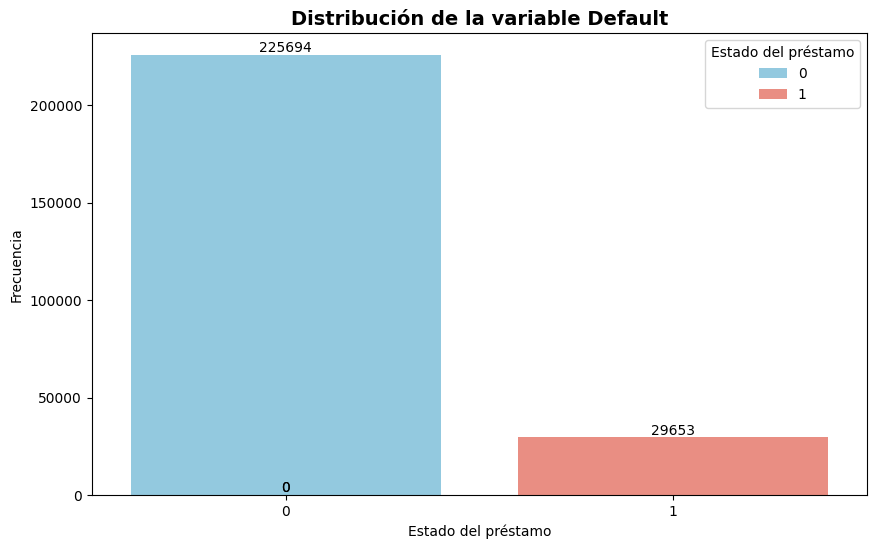

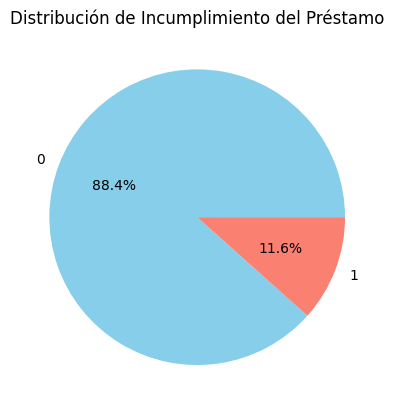

In [3]:
df = pd.read_csv(dataset_path)
default_counts = df['Default'].value_counts()

data = pd.DataFrame({
    'Estado del préstamo': default_counts.index,
    'Frecuencia': default_counts.values
})

color_palette = {0: 'skyblue', 1: 'salmon'}
plt.figure(figsize=(10, 6))

ax = sns.barplot(x='Estado del préstamo', y='Frecuencia', data=data, palette=color_palette, hue='Estado del préstamo', errorbar=None)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Distribución de la variable Default', fontsize=14, weight='bold')
plt.show()

# Gráfico de pastel
default_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title('Distribución de Incumplimiento del Préstamo')
plt.ylabel('')
plt.show()

# Distribucion variables de entrada

**Variable:** Age  

**Distribución de los datos:** distribución relativamente uniforme entre las edades de 18 a 69 años. Las edades más frecuentes se encuentran en el rango de 33 a 40 años, con el valor más alto en 40 años (5056).

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  Las personas más jóvenes parecen tener una mayor tasa de incumplimiento de préstamos, ya que el rango de edades en los incumplidores está más hacia el rango más joven. A medida que la edad aumenta, la probabilidad de incumplimiento parece disminuir, como lo sugiere el hecho de que la mayor parte del grupo sin incumplimiento está compuesto por personas mayores.

**Transformación:** Normalizar, para que esté en un rango común con las demás variables.  

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

Age
18    4884
19    4963
20    4861
21    4889
22    4970
23    4740
24    4869
25    4840
26    4891
27    4945
28    4906
29    4865
30    4954
31    4908
32    4969
33    5022
34    4987
35    4961
36    4906
37    4856
38    4955
39    4973
40    5056
41    4815
42    4803
43    4965
44    4906
45    4985
46    4887
47    4931
48    4810
49    4952
50    4949
51    4876
52    4748
53    5010
54    4921
55    5064
56    4902
57    4925
58    4883
59    4871
60    4772
61    4982
62    4999
63    4862
64    4840
65    5027
66    4841
67    4876
68    4958
69    4817
Name: count, dtype: int64


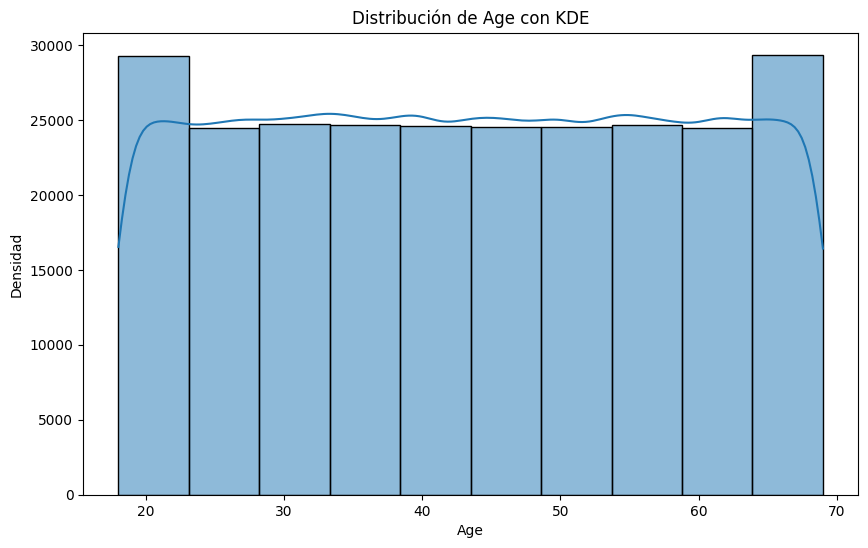

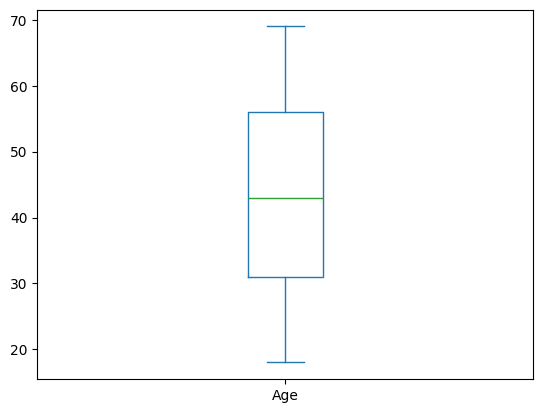

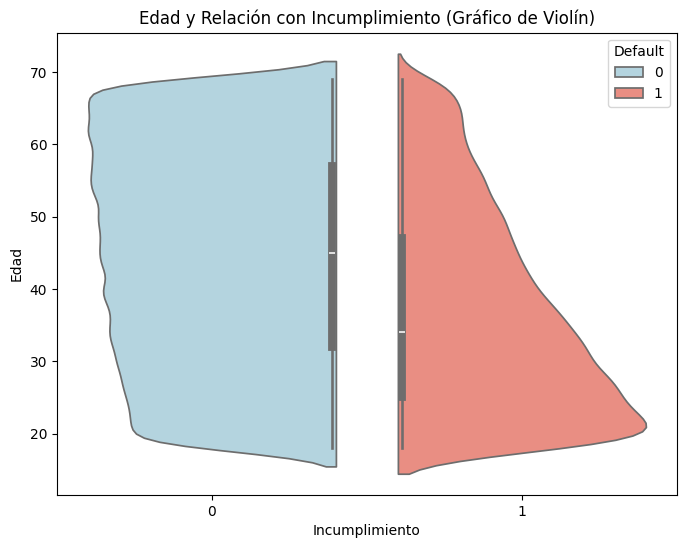

In [4]:
# Distribución de 'Age'
age = df['Age'].value_counts()
print(age.sort_index())

# Convertir a DataFrame
age_df = pd.DataFrame(list(age.items()), columns=['Age', 'Count'])

# Graficar en formato de histograma
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=10, kde=True)
plt.title('Distribución de Age con KDE')
plt.xlabel('Age')
plt.ylabel('Densidad')
plt.show()

# Boxplot de 'Age'
df['Age'].plot.box()

# Age' vs 'Default'
plt.figure(figsize=(8, 6))
sns.violinplot(x='Default', y='Age', data=df, hue='Default', palette=['lightblue', 'salmon'], split=True)
plt.title('Edad y Relación con Incumplimiento (Gráfico de Violín)')
plt.xlabel('Incumplimiento')
plt.ylabel('Edad')
plt.show()

**Variable:** Income  

**Distribución de los datos:** distribución uniforme entre ingresos de 15000 a 14999.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** las personas con un ingreso más bajo tienden a tener un mayor riesgo de incumplimiento.

**Transformación:** Normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

Income
15000     3
15001     2
15002     2
15003     1
15004     2
         ..
149994    4
149995    1
149996    3
149997    2
149999    2
Name: count, Length: 114620, dtype: int64


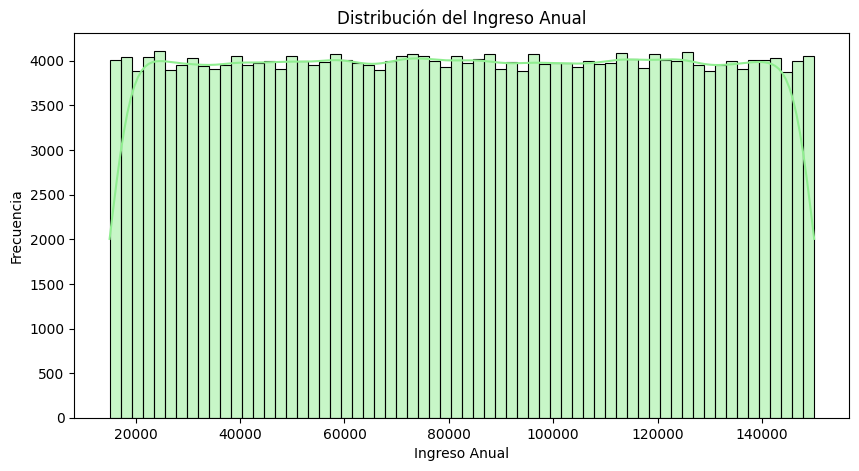

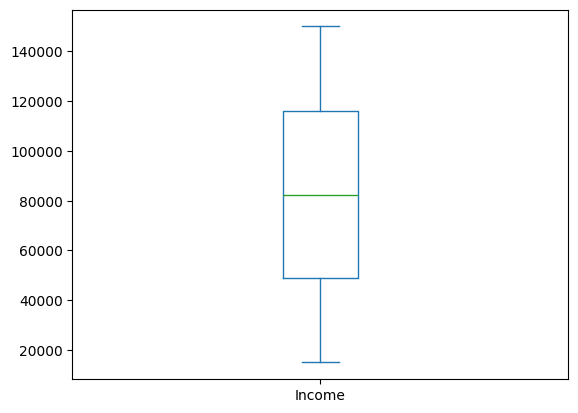

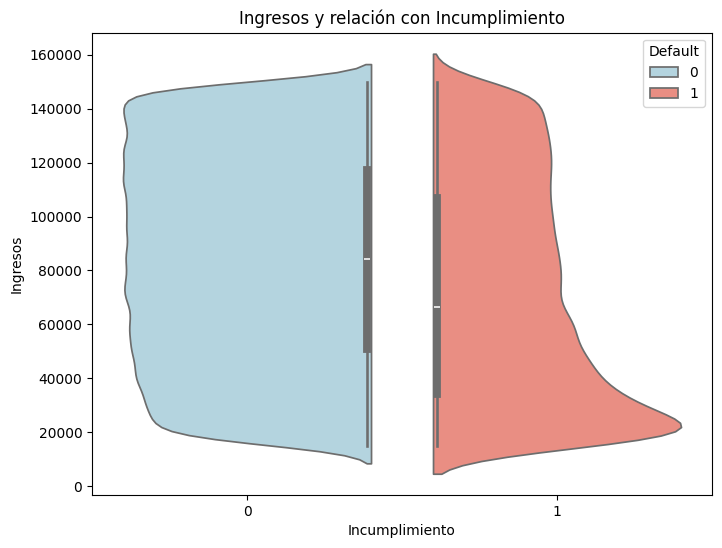

In [5]:
# Income (Ingreso Anual)
Income = df['Income'].value_counts()
print(Income.sort_index())

# Histograma de la variable 'Income'
plt.figure(figsize=(10, 5))
sns.histplot(df['Income'], kde=True, color='lightgreen')
plt.title('Distribución del Ingreso Anual')
plt.xlabel('Ingreso Anual')
plt.ylabel('Frecuencia')
plt.show()
# Boxplot de la variable 'Income'
df['Income'].plot.box()

# 'Income' vs 'Default'
plt.figure(figsize=(8, 6))
sns.violinplot(x='Default', y='Income', data=df, hue='Default', palette=['lightblue', 'salmon'], split=True)
plt.title('Ingresos y relación con Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Ingresos')
plt.show()


**Variable:** CreditScore  

**Distribución de los datos:** distribución uniforme entre credit score de 300 a 849.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** un puntaje de crédito más bajo está ligeramente asociado con un mayor riesgo de incumplimiento, pero la relación no es fuerte.

**Transformación:** Normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles y algunas prácticamente nulas (por ejemplo con NumCreditLines).

CreditScore
300    484
301    460
302    451
303    489
304    456
      ... 
845    438
846    437
847    450
848    463
849    496
Name: count, Length: 550, dtype: int64


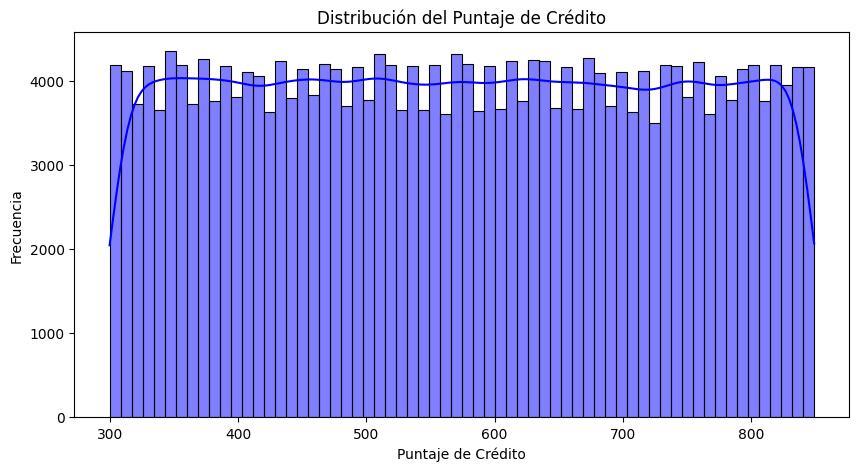

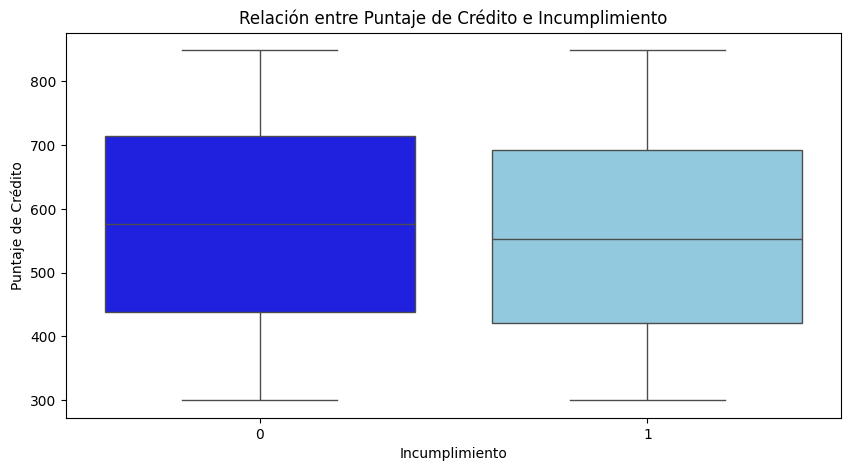

In [6]:
# CreditScore (Puntaje de Crédito)
CreditScore = df['CreditScore'].value_counts()
print(CreditScore.sort_index())

# Histograma de la variable 'CreditScore'
plt.figure(figsize=(10, 5))
sns.histplot(df['CreditScore'], kde=True, color='blue')
plt.title('Distribución del Puntaje de Crédito')
plt.xlabel('Puntaje de Crédito')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'CreditScore' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='CreditScore', hue='Default', data=df, palette=['blue', 'skyblue'], legend=False)
plt.title('Relación entre Puntaje de Crédito e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Puntaje de Crédito')
plt.show()


**Variable:** LoanAmount  

**Distribución de los datos:** distribución uniforme entre monto del préstamo de 5000 a 249999.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** en general, los préstamos de mayor monto podrían están algo asociados con un mayor riesgo de incumplimiento.

**Transformación:** Normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles y algunas prácticamente nulas (por ejemplo con HasDependents y LoanPurpose).

LoanAmount
5000      1
5001      1
5005      1
5006      1
5009      2
         ..
249993    2
249996    1
249997    1
249998    1
249999    1
Name: count, Length: 158729, dtype: int64


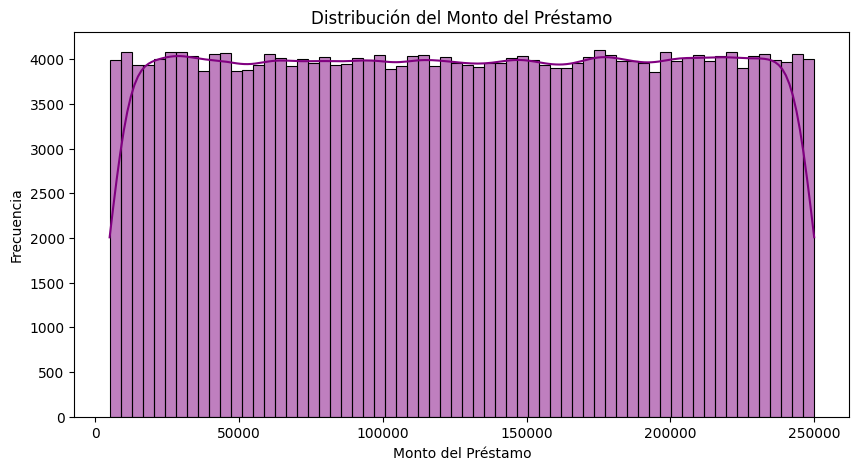

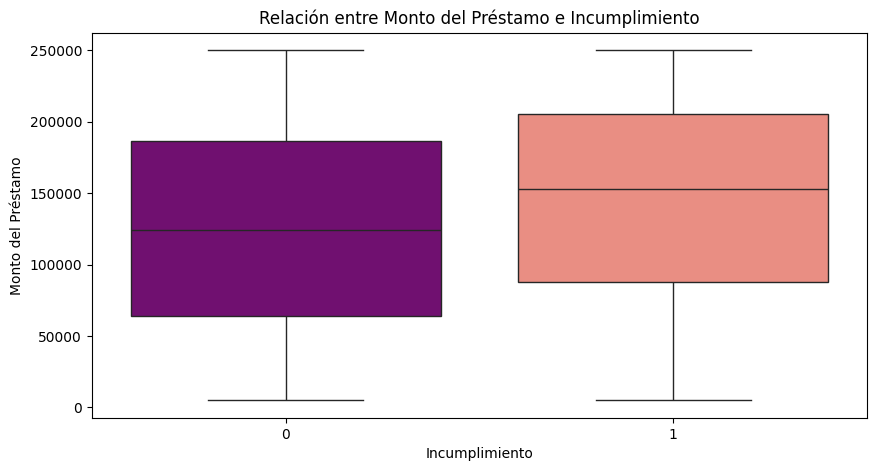

In [25]:
# LoanAmount (Monto del Préstamo)
LoanAmount = df['LoanAmount'].value_counts()
print(LoanAmount.sort_index())

# Histograma de la variable 'LoanAmount'
plt.figure(figsize=(10, 5))
sns.histplot(df['LoanAmount'], kde=True, color='purple')
plt.title('Distribución del Monto del Préstamo')
plt.xlabel('Monto del Préstamo')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'LoanAmount' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='LoanAmount', hue='Default', data=df, palette=['purple', 'salmon'], legend=False)
plt.title('Relación entre Monto del Préstamo e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Monto del Préstamo')
plt.show()


**Variable:** DTIRatio  

**Distribución de los datos:** distribución uniforme (con picos -> ver de poner bien a que distribucion ajusta), entre DTIRatio de 0.1 a 0.9.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** un mayor DTIRatio puede estar asociado con un mayor riesgo de incumplimiento, aunque la relación es bastante débil.

**Transformación:** -

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

DTIRatio
0.10    1611
0.11    3051
0.12    3224
0.13    3285
0.14    3228
        ... 
0.86    3274
0.87    3152
0.88    3168
0.89    3134
0.90    1605
Name: count, Length: 81, dtype: int64


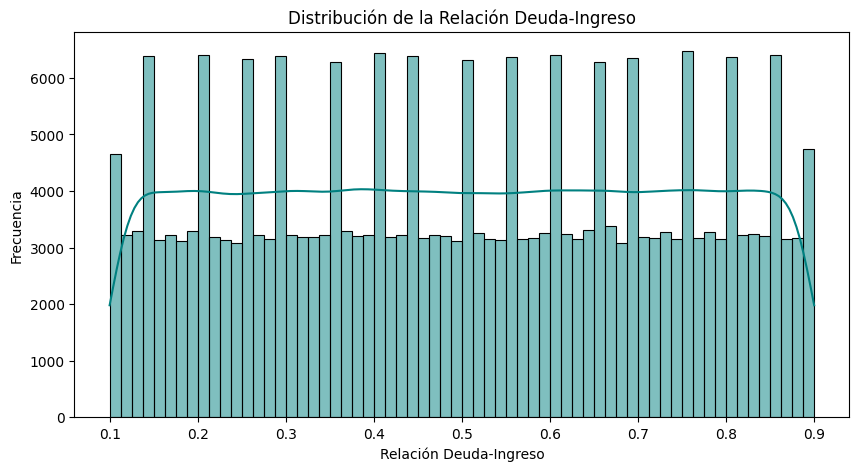

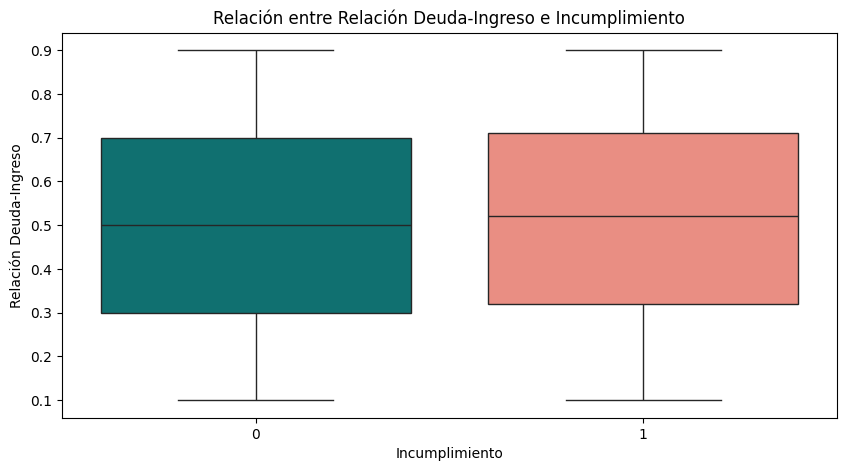

In [26]:
# DTIRatio (Relación Deuda-Ingreso)
DTIRatio = df['DTIRatio'].value_counts()
print(DTIRatio.sort_index())

# Histograma de la variable 'DTIRatio'
plt.figure(figsize=(10, 5))
sns.histplot(df['DTIRatio'], kde=True, color='teal')
plt.title('Distribución de la Relación Deuda-Ingreso')
plt.xlabel('Relación Deuda-Ingreso')
plt.ylabel('Frecuencia')
plt.show()

# Boxplot de 'DTIRatio' vs 'Default'
plt.figure(figsize=(10, 5))
sns.boxplot(x='Default', y='DTIRatio', hue='Default', data=df, palette=['teal', 'salmon'], legend=False)
plt.title('Relación entre Relación Deuda-Ingreso e Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Relación Deuda-Ingreso')
plt.show()

**Variable:** EmploymentType  

**Distribución de los datos:** distribución uniforme.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** no se puede concluir que ciertos tipos de empleo pueden estar asociados con un mayor riesgo de incumplimiento, porque la relación es bastante débil.

**Transformación:** one hot encoding, para convertir cada categoría en una columna binaria.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** casi todas las correlaciones son nulas, sólo algunas son debilmente negativas o positivas.

EmploymentType
Full-time        63656
Part-time        64161
Self-employed    63706
Unemployed       63824
Name: count, dtype: int64
EmploymentType
Full-time        63656
Part-time        64161
Self-employed    63706
Unemployed       63824
Name: count, dtype: int64


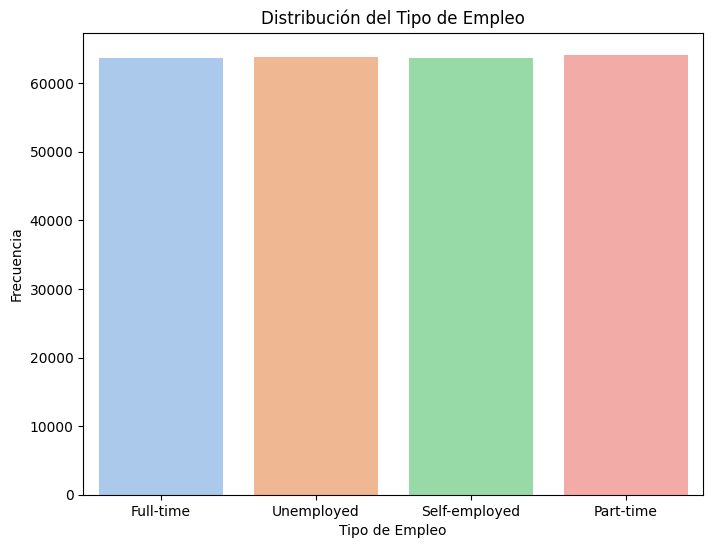

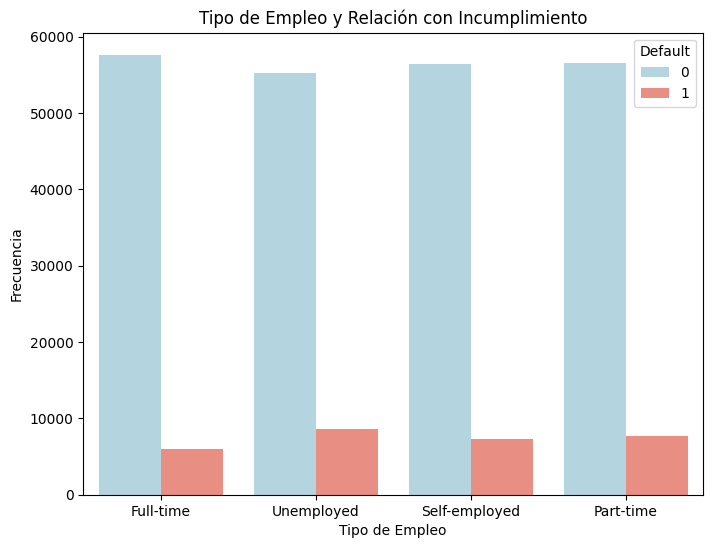

In [27]:
# EmploymentType (Tipo de Empleo)
EmploymentType = df['EmploymentType'].value_counts()
print(EmploymentType.sort_index())

# Frecuencia de cada tipo de empleo
employment_counts = df['EmploymentType'].value_counts()
print(employment_counts.sort_index())

# Gráfico de barras de 'EmploymentType'
plt.figure(figsize=(8, 6))
sns.countplot(x='EmploymentType', data=df, hue='EmploymentType', palette='pastel', legend=False)
plt.title('Distribución del Tipo de Empleo')
plt.xlabel('Tipo de Empleo')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras para 'EmploymentType' vs 'Default'
plt.figure(figsize=(8, 6))
sns.countplot(x='EmploymentType', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Tipo de Empleo y Relación con Incumplimiento')
plt.xlabel('Tipo de Empleo')
plt.ylabel('Frecuencia')
plt.show()

**Variable:** HasDependents  

**Distribución de los datos:** casi mitad y mitad (Ver bien como poner)

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** tener dependientes puede estar asociado con una menor probabilidad de incumplimiento.

**Transformación:** -

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

HasDependents
No     49.973174
Yes    50.026826
Name: proportion, dtype: float64


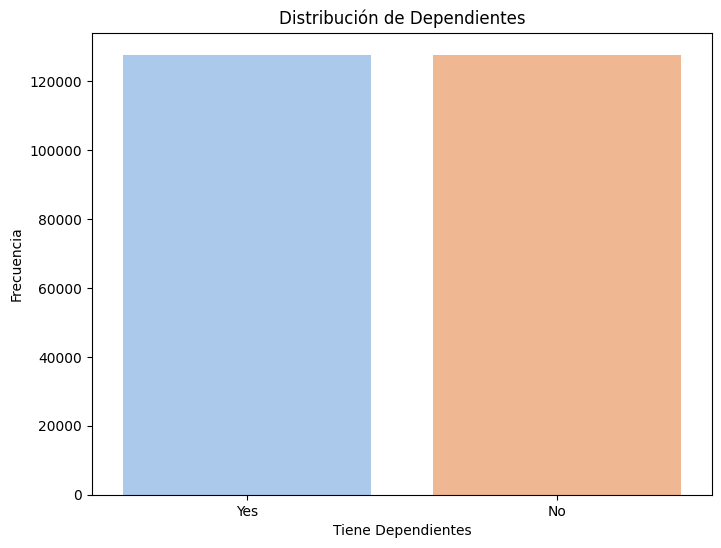

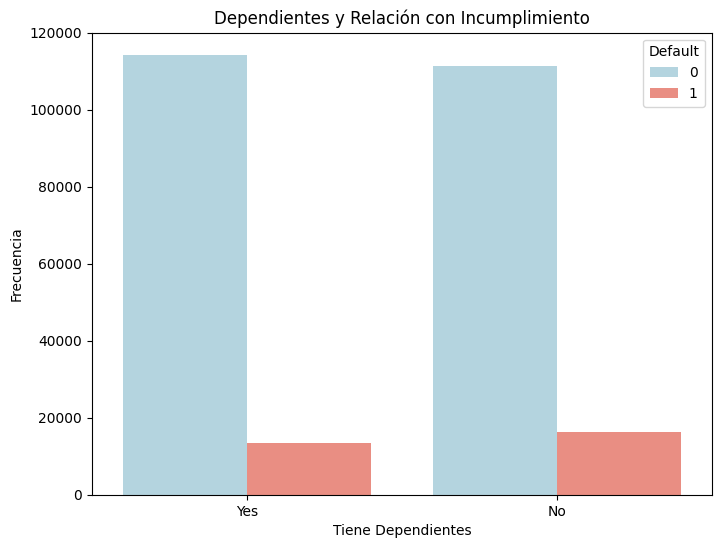

In [28]:
# HasDependents (Tiene Dependientes)

# Distribución de 'HasDependents'
dependents_dist = df['HasDependents'].value_counts(normalize=True) * 100
print(dependents_dist.sort_index())

# Gráfico de barras de 'HasDependents'
plt.figure(figsize=(8, 6))
sns.countplot(x='HasDependents', data=df, hue='HasDependents', palette='pastel', legend=False)
plt.title('Distribución de Dependientes')
plt.xlabel('Tiene Dependientes')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras para 'HasDependents' vs 'Default'
plt.figure(figsize=(8, 6))
sns.countplot(x='HasDependents', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Dependientes y Relación con Incumplimiento')
plt.xlabel('Tiene Dependientes')
plt.ylabel('Frecuencia')
plt.show()

LoanPurpose (Propósito del Préstamo)

**Variable:** LoanPurpose  

**Distribución de los datos:** 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** no se observa que el propósito del préstamo puede tener una asociación con una menor o mayor probabilidad de incumplimiento.

**Transformación:** one hot encoding, para convertir cada categoría en una columna binaria.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

LoanPurpose
Auto         50844
Business     51298
Education    51005
Home         51286
Other        50914
Name: count, dtype: int64


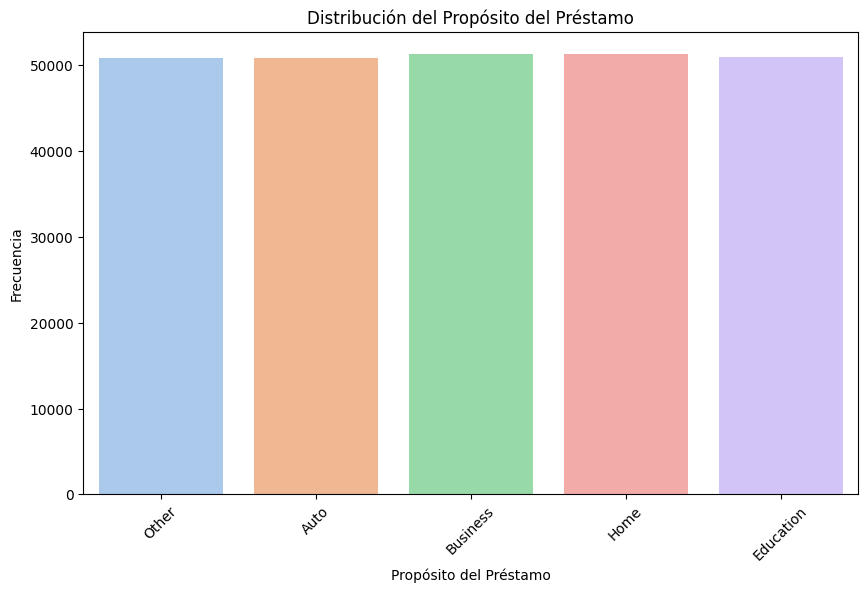

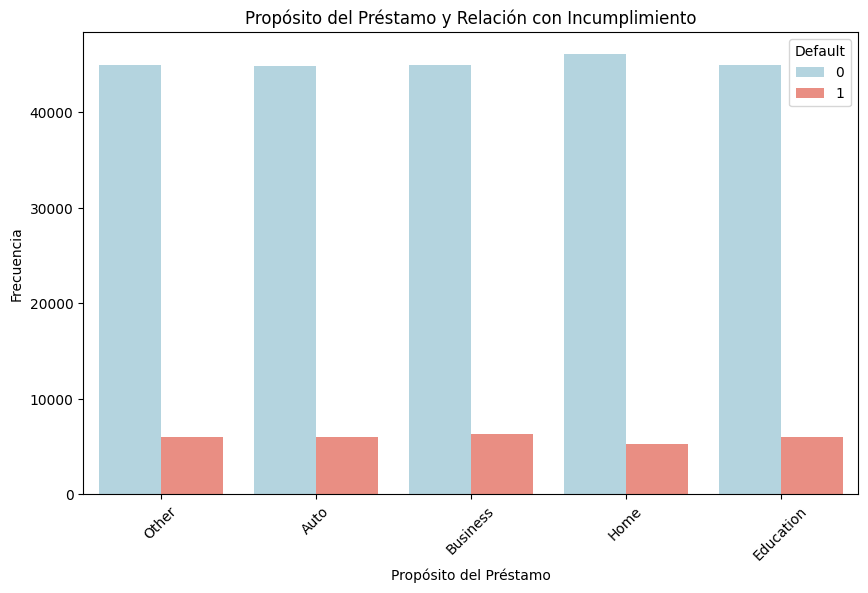

In [29]:
# Frecuencia de cada propósito del préstamo
purpose_counts = df['LoanPurpose'].value_counts()
print(purpose_counts.sort_index())

# Gráfico de barras de 'LoanPurpose'
plt.figure(figsize=(10, 6))
sns.countplot(x='LoanPurpose', data=df, hue='LoanPurpose', palette='pastel', legend=False)
plt.title('Distribución del Propósito del Préstamo')
plt.xlabel('Propósito del Préstamo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'LoanPurpose' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='LoanPurpose', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Propósito del Préstamo y Relación con Incumplimiento')
plt.xlabel('Propósito del Préstamo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

MaritalStatus (Estado Civil)

**Variable:** MaritalStatus  

**Distribución de los datos:** 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** se identifica una relación débil.

**Transformación:** -

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

MaritalStatus
Divorced    85033
Married     85302
Single      85012
Name: count, dtype: int64


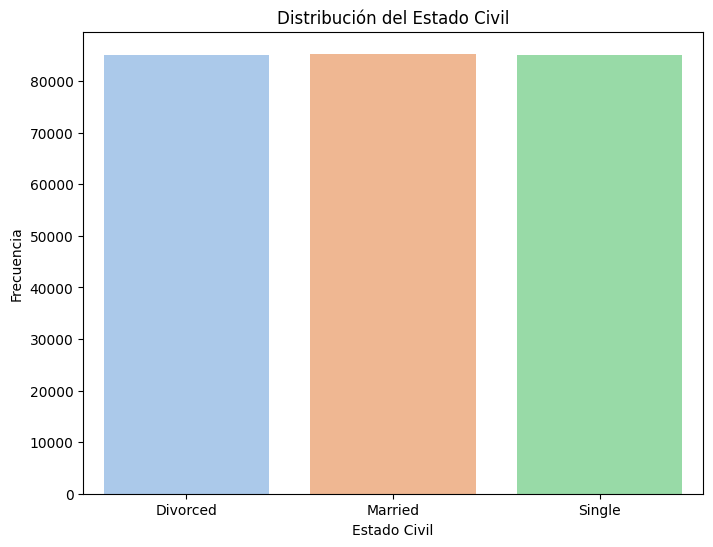

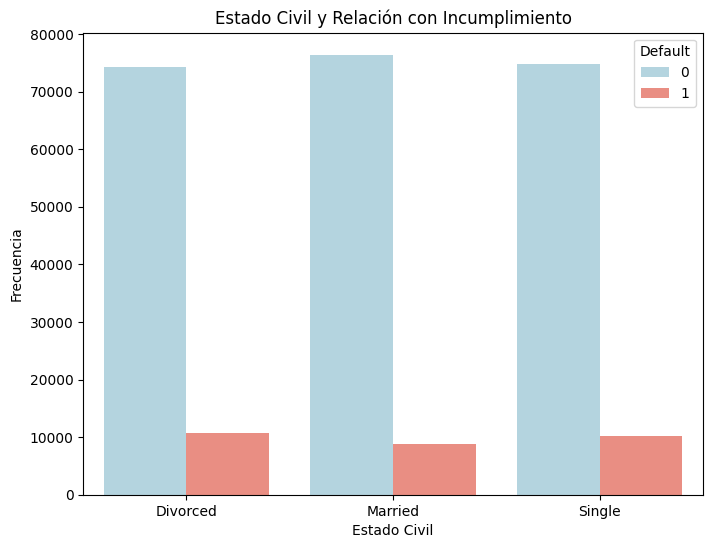

In [30]:
# Frecuencia de cada estado civil
marital_status_counts = df['MaritalStatus'].value_counts()
print(marital_status_counts.sort_index())

# Gráfico de barras de 'MaritalStatus'
plt.figure(figsize=(8, 6))
sns.countplot(x='MaritalStatus', data=df, hue='MaritalStatus', palette='pastel', legend=False)
plt.title('Distribución del Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras para 'MaritalStatus' vs 'Default'
plt.figure(figsize=(8, 6))
sns.countplot(x='MaritalStatus', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Estado Civil y Relación con Incumplimiento')
plt.xlabel('Estado Civil')
plt.ylabel('Frecuencia')
plt.show()

**Variable:** MonthsEmployed  

**Distribución de los datos:** 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** se identifica una relación débil, aunque se observa que el rango de personas que incumplen, es ligeramente mayor en personas con poco tiempo de tener un trabajo.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

MonthsEmployed
0      2122
1      2105
2      2151
3      2167
4      2121
       ... 
115    2084
116    2130
117    2084
118    2196
119    2091
Name: count, Length: 120, dtype: int64


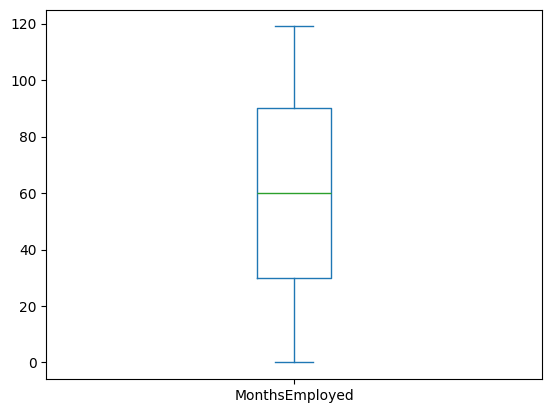

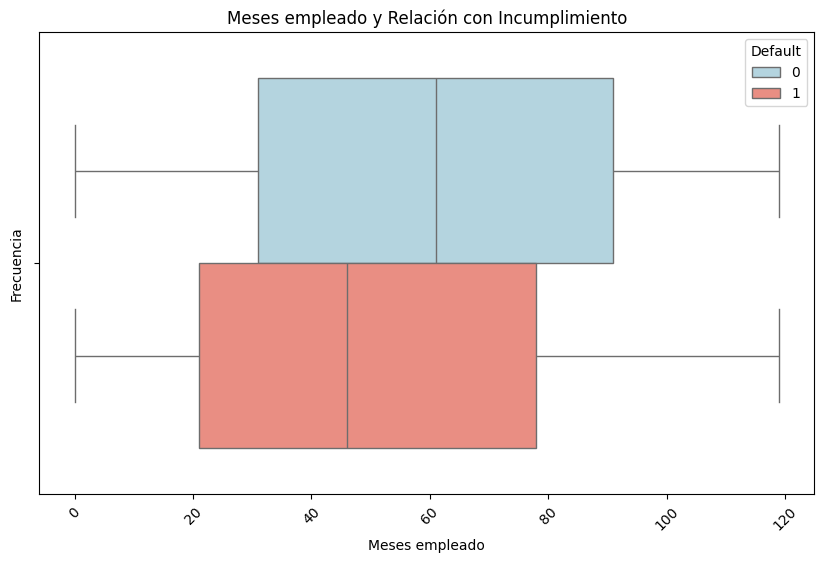

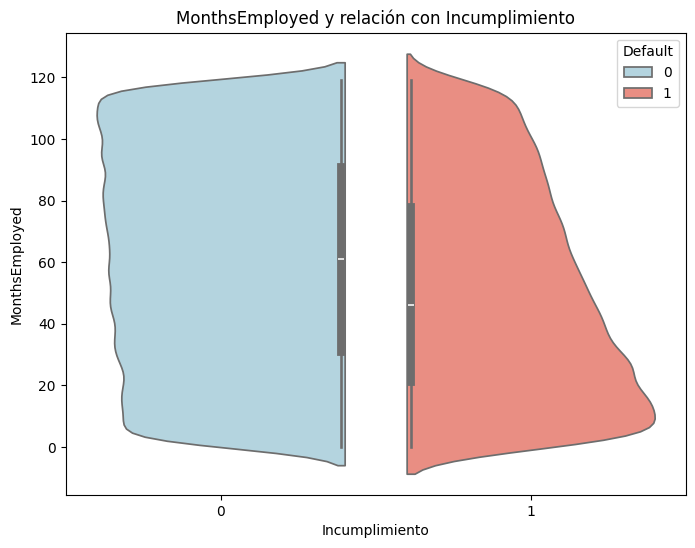

In [31]:
# MonthsEmployed (Meses que la persona ha estado empleado) 
months_employed = df['MonthsEmployed'].value_counts()
print(months_employed.sort_index())

# # Boxplot de 'MonthsEmployed'
df['MonthsEmployed'].plot.box()

# Gráfico de barras para 'MonthsEmployed' vs 'Default'
plt.figure(figsize=(10, 6))
sns.boxplot(x='MonthsEmployed', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Meses empleado y Relación con Incumplimiento')
plt.xlabel('Meses empleado')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show

# 'MonthsEmployed' vs 'Default'
plt.figure(figsize=(8, 6))
sns.violinplot(x='Default', y='MonthsEmployed', data=df, hue='Default', palette=['lightblue', 'salmon'], split=True)
plt.title('MonthsEmployed y relación con Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('MonthsEmployed')
plt.show()

**Variable:** NumCreditLines  

**Distribución de los datos:** uniforme.

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** se concluye que a mayor número de líneas de crédito, hay un mayor (aunque muy pequeño), incremento de riesgo de incumplimiento.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

NumCreditLines
1    63554
2    64130
3    63834
4    63829
Name: count, dtype: int64


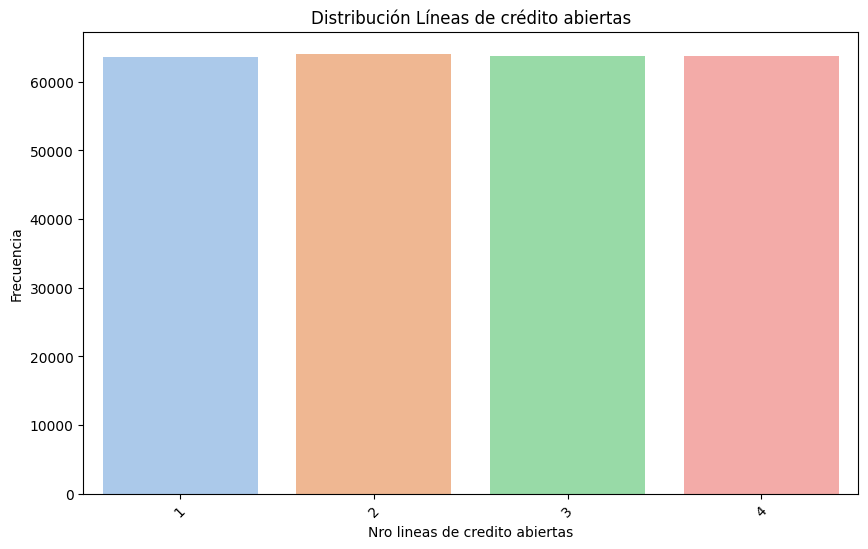

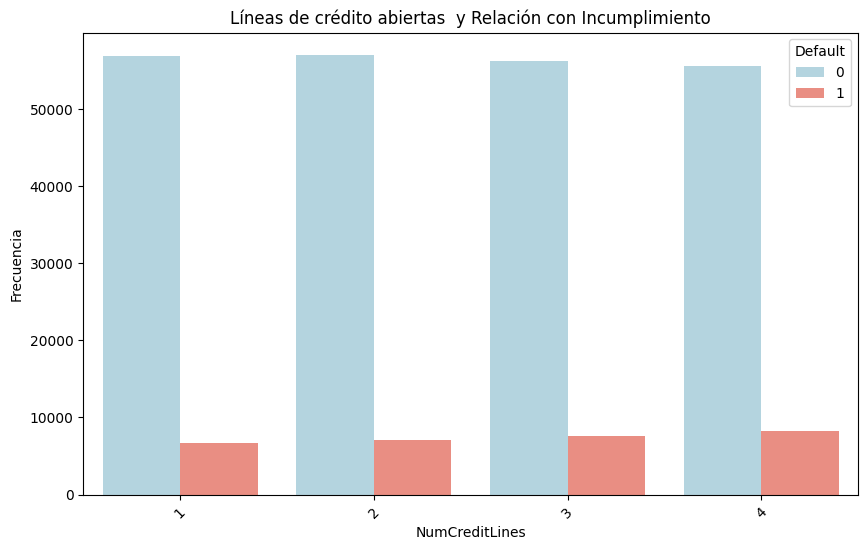

In [32]:
# NumCreditLines (Líneas de crédito abiertas)
num_CreditLines = df['NumCreditLines'].value_counts()
print(num_CreditLines.sort_index())

# Gráfico de barras de 'NumCreditLines'
plt.figure(figsize=(10, 6))
sns.countplot(x='NumCreditLines', data=df, hue='NumCreditLines', palette='pastel', legend=False)
plt.title('Distribución Líneas de crédito abiertas')
plt.xlabel('Nro lineas de credito abiertas')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'NumCreditLines' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='NumCreditLines', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Líneas de crédito abiertas  y Relación con Incumplimiento')
plt.xlabel('NumCreditLines')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** InterestRate  

**Distribución de los datos:** 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** a medida que la tasa de interés aumenta, la probabilidad de incumplimiento también tiende a aumentar.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

InterestRate
2.00      44
2.01     110
2.02     108
2.03     104
2.04     109
        ... 
24.96    126
24.97    118
24.98    113
24.99     96
25.00     53
Name: count, Length: 2301, dtype: int64


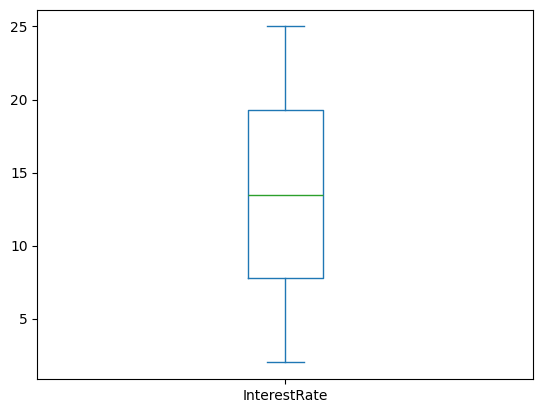

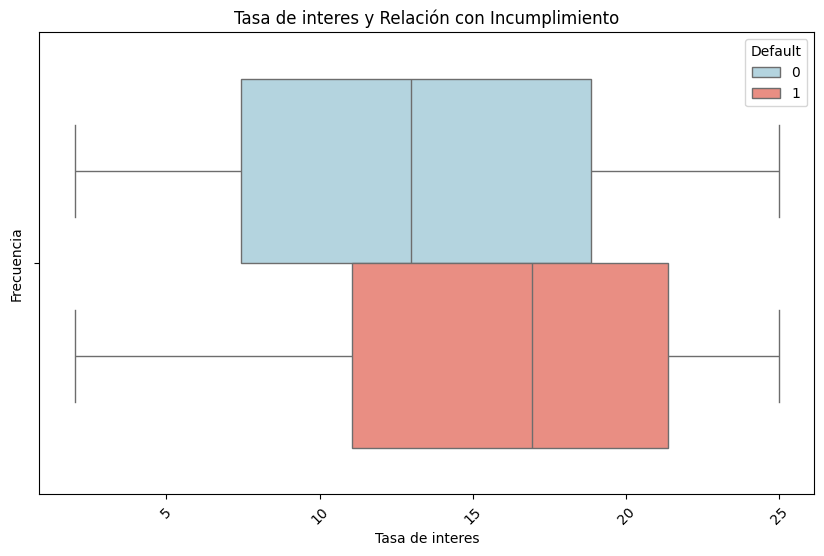

In [33]:
# InterestRate (Tasa de interés del préstamo)
interest_Rate = df['InterestRate'].value_counts()
print(interest_Rate.sort_index())

# Boxplot de 'InterestRate'
df['InterestRate'].plot.box()

# Gráfico de barras para 'InterestRate' vs 'Default'
plt.figure(figsize=(10, 6))
sns.boxplot(x='InterestRate', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Tasa de interes y Relación con Incumplimiento')
plt.xlabel('Tasa de interes')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** LoanTerm  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:** no influye en la probabilidad de incumplimiento del dataset.

**Transformación:** normalizar.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

LoanTerm
12    50957
24    51009
36    51061
48    51166
60    51154
Name: count, dtype: int64


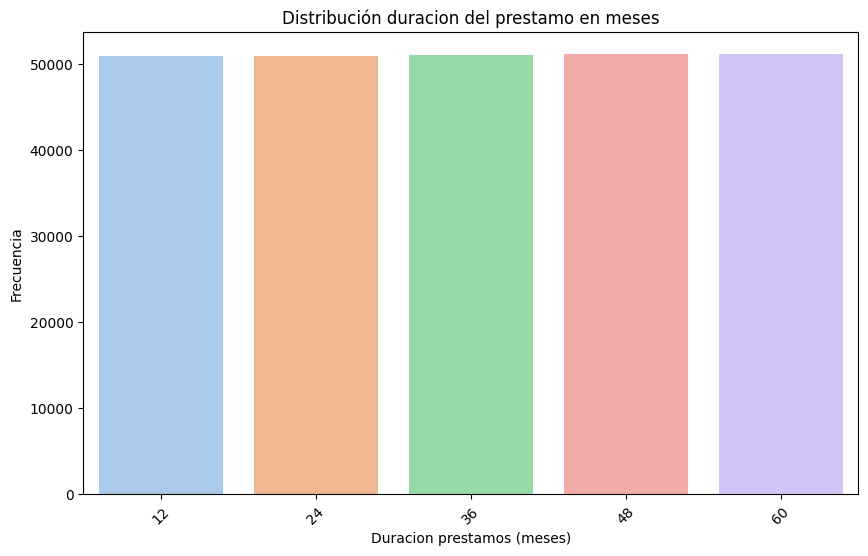

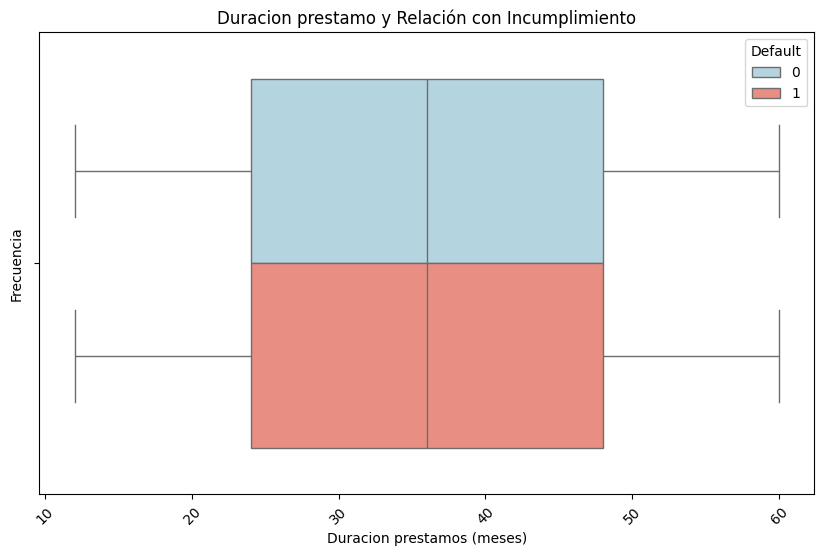

In [34]:
# LoanTerm (Duración del préstamo en meses) 
Loan_Term = df['LoanTerm'].value_counts()
print(Loan_Term.sort_index())

# Gráfico de barras de 'LoanTerm'
plt.figure(figsize=(10, 6))
sns.countplot(x='LoanTerm', data=df, hue='LoanTerm', palette='pastel', legend=False)
plt.title('Distribución duracion del prestamo en meses')
plt.xlabel('Duracion prestamos (meses)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'LoanTerm' vs 'Default'
plt.figure(figsize=(10, 6))
sns.boxplot(x='LoanTerm', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Duracion prestamo y Relación con Incumplimiento')
plt.xlabel('Duracion prestamos (meses)')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** Education  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  no hay una relación significativa entre el nivel educativo y la probabilidad de incumplimiento.

**Transformación:** one hot encoding, para convertir cada categoría en una columna binaria.

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

Education
Bachelor's     64366
High School    63903
Master's       63541
PhD            63537
Name: count, dtype: int64


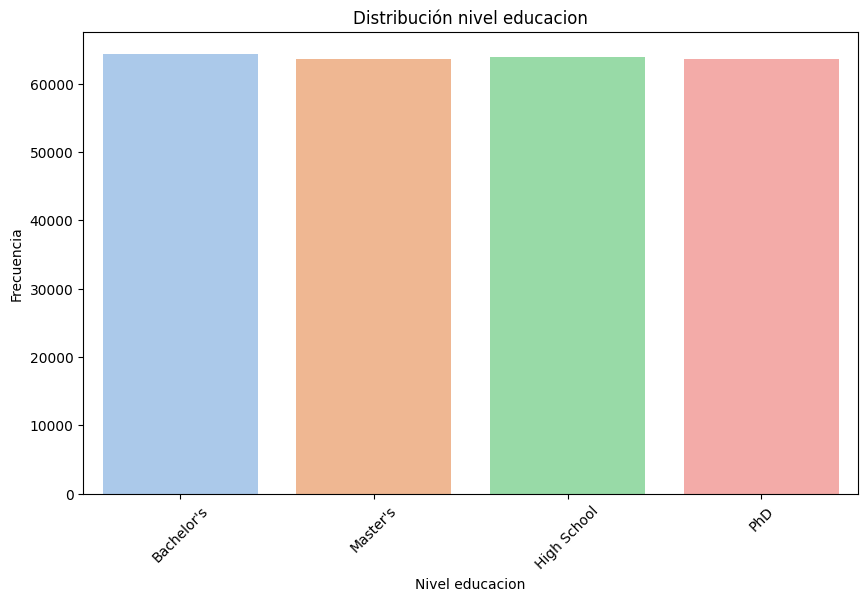

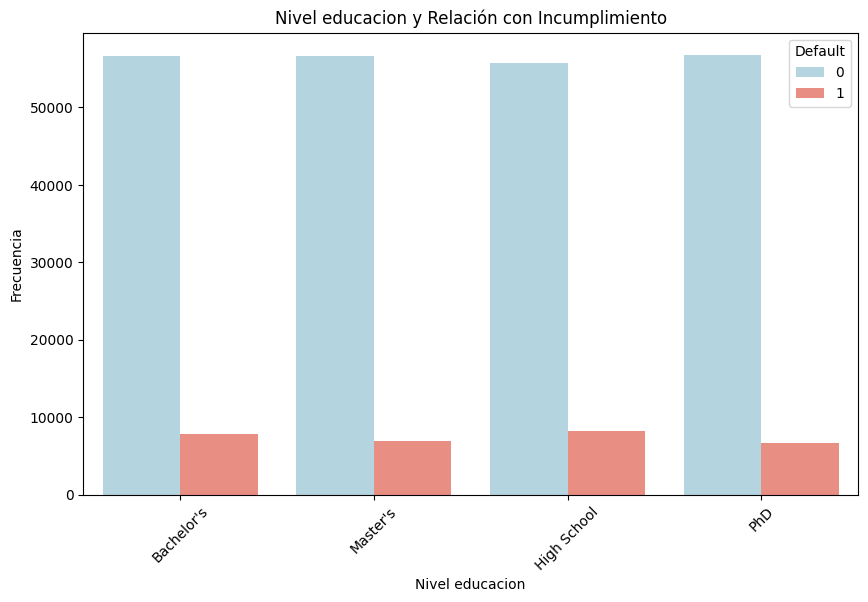

In [35]:
# Education (nivel educativo)
Education = df['Education'].value_counts()
print(Education.sort_index())

# Gráfico de barras de 'MonthsEmployed'
plt.figure(figsize=(10, 6))
sns.countplot(x='Education', data=df, hue='Education', palette='pastel', legend=False)
plt.title('Distribución nivel educacion')
plt.xlabel('Nivel educacion')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'Education' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='Education', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Nivel educacion y Relación con Incumplimiento')
plt.xlabel('Nivel educacion')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** HasMortgage  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  tener una hipoteca disminuye ligeramente la posibilidad de incumplimiento.

**Transformación:** -

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

HasMortgage
No     127670
Yes    127677
Name: count, dtype: int64


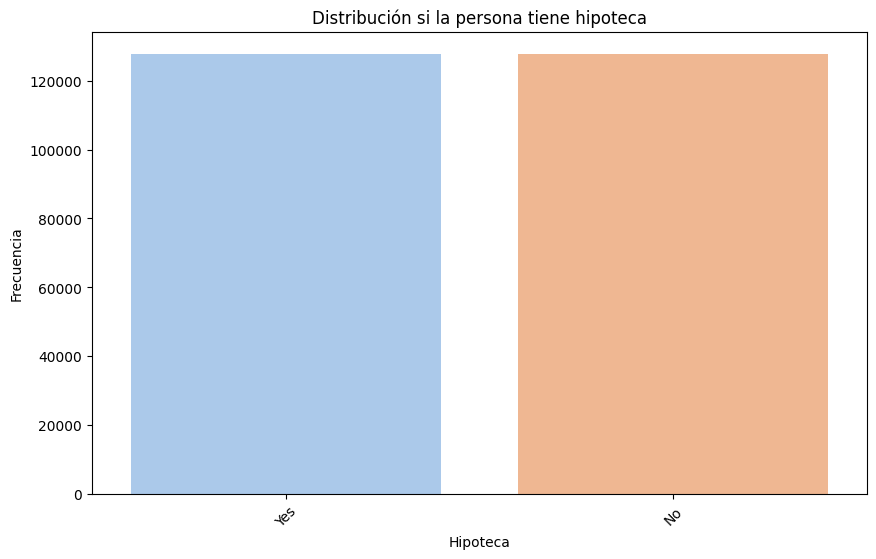

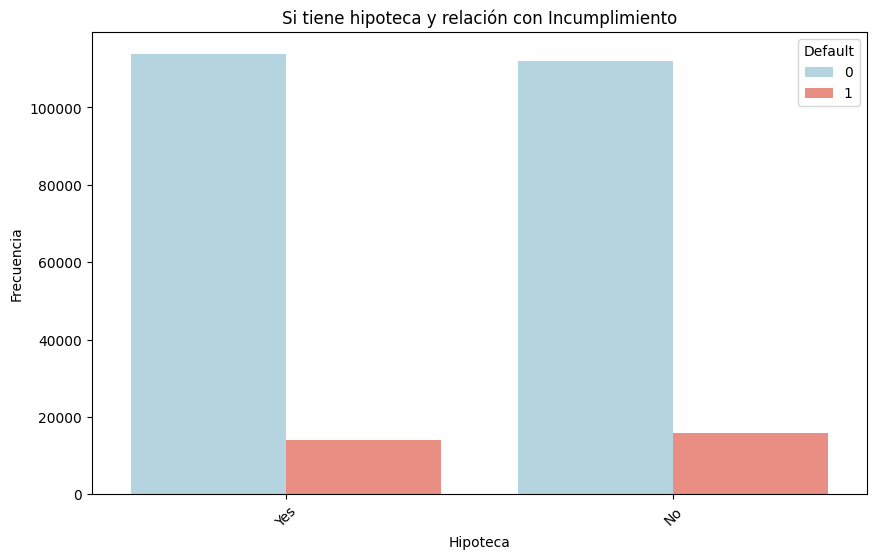

In [36]:
# HasMortgage (si la persona tiene una hipoteca)
Has_Mortgage = df['HasMortgage'].value_counts()
print(Has_Mortgage.sort_index())

# Gráfico de barras de 'HasMortgage'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasMortgage', data=df, hue='HasMortgage', palette='pastel', legend=False)
plt.title('Distribución si la persona tiene hipoteca')
plt.xlabel('Hipoteca')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'HasMortgage' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasMortgage', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Si tiene hipoteca y relación con Incumplimiento')
plt.xlabel('Hipoteca')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

**Variable:** HasCoSigner  

**Distribución de los datos:** uniforme. 

**Valores raros o atípicos:**  no hay.

**Relación con la variable de salida:**  no tener un garante aumenta la posibilidad de incumplimiento.

**Transformación:** -

**Valores nulos o extremos:** no hay.

**Correlación con otras variables:** sólo hay correlaciones débiles.

HasCoSigner
No     127646
Yes    127701
Name: count, dtype: int64


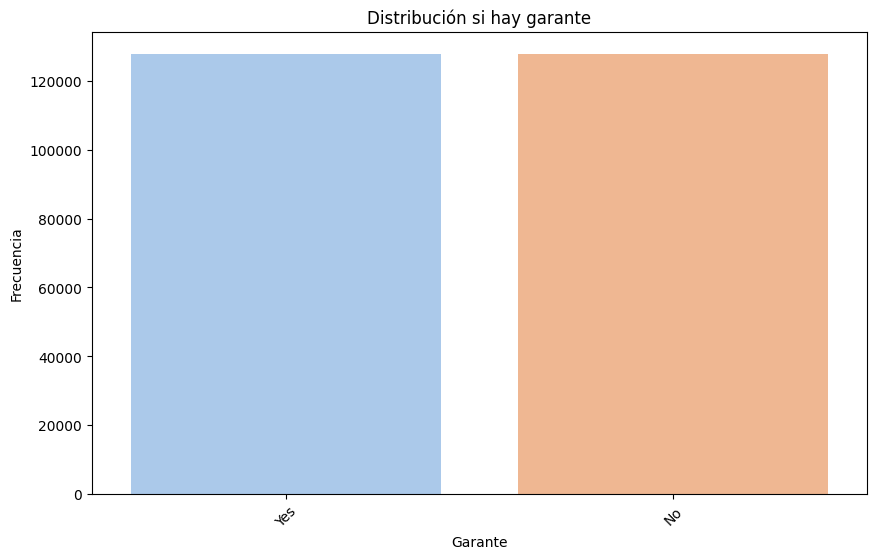

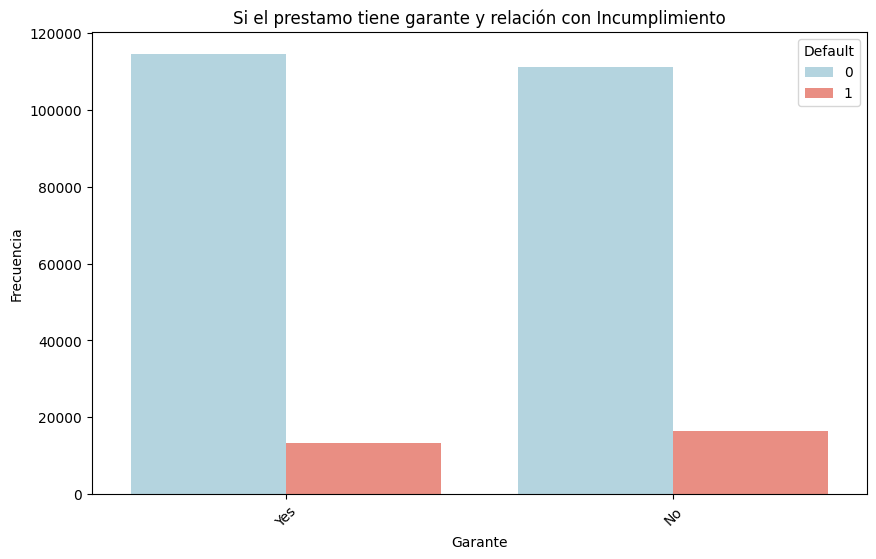

In [37]:
# Si el préstamo tiene un garante 
Has_CoSigner = df['HasCoSigner'].value_counts()
print(Has_CoSigner.sort_index())

# Gráfico de barras de 'HasCoSigner'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasCoSigner', data=df, hue='HasCoSigner', palette='pastel', legend=False)
plt.title('Distribución si hay garante')
plt.xlabel('Garante')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

# Gráfico de barras para 'HasCoSigner' vs 'Default'
plt.figure(figsize=(10, 6))
sns.countplot(x='HasCoSigner', hue='Default', data=df, palette=['lightblue', 'salmon'])
plt.title('Si el prestamo tiene garante y relación con Incumplimiento')
plt.xlabel('Garante')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [38]:
# Correlación entre las variables
from sklearn.preprocessing import LabelEncoder

# Codificar variables categóricas
label_encoder = LabelEncoder()

categorical_columns = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

# Seleccionar solo las variables numéricas
df_numeric = df.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

print(correlation_matrix)

                     Age    Income  LoanAmount  CreditScore  MonthsEmployed  \
Age             1.000000 -0.001244   -0.002213    -0.000548       -0.000341   
Income         -0.001244  1.000000   -0.000865    -0.001430        0.002675   
LoanAmount     -0.002213 -0.000865    1.000000     0.001261        0.002817   
CreditScore    -0.000548 -0.001430    0.001261     1.000000        0.000613   
MonthsEmployed -0.000341  0.002675    0.002817     0.000613        1.000000   
NumCreditLines -0.000890 -0.002016    0.000794     0.000016        0.001267   
InterestRate   -0.001127 -0.002303   -0.002291     0.000436        0.000096   
LoanTerm        0.000263 -0.000998    0.002538     0.001130       -0.001166   
DTIRatio       -0.004689  0.000205    0.001122    -0.001039        0.001765   
Education      -0.000882 -0.000965    0.002551     0.000214       -0.001304   
EmploymentType  0.000787 -0.005146    0.003060     0.003503        0.000564   
MaritalStatus  -0.002187  0.000637   -0.000771    -0

Correlaciones Generales
Default: La variable de interés Default tiene una correlación de -0.1678 con Age, que es una correlación moderada negativa. Esto sugiere que, en general, las personas mayores pueden tener una menor probabilidad de incumplir con el préstamo, aunque esta relación aún no es muy fuerte.

Variables Financieras:

Income: Tiene una correlación positiva moderada con Default (0.1313), sugiriendo que mayores ingresos podrían estar asociados con un menor incumplimiento.
LoanAmount: La correlación con Default es 0.0867, indicando una relación positiva débil.
CreditScore: La correlación con Default es -0.0342, muy débil y negativa, lo que sugiere que el puntaje de crédito no tiene una fuerte relación lineal con el incumplimiento.

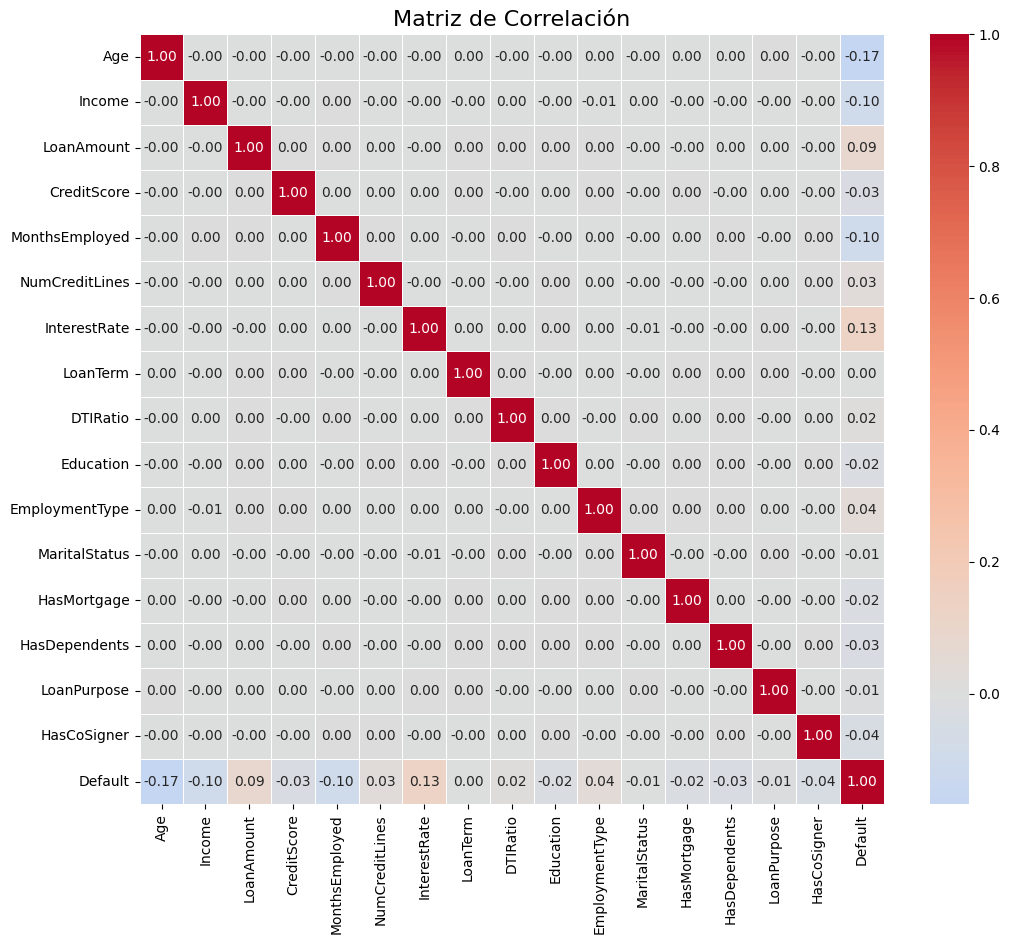

In [39]:
# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 10))

# Crear el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)

# Añadir título
plt.title('Matriz de Correlación', fontsize=16)

# Mostrar el gráfico
plt.show()


Relaciones Lineales

Income y Default:
Correlación: -0.099119 (-0.10 redondeado).
Ingresos más altos están ligeramente asociados con una menor probabilidad de incumplimiento.

InterestRate y Default:
Correlación: 0.131273
Ppréstamos con tasas de interés más altas están asociados con un mayor riesgo de incumplimiento.


Preguntas/dudas:

0- ¿Hay alguna variable que creas que es especialmente importante para el análisis que no está claramente documentada en el dataset?

1- ¿Cómo se manejan los valores faltantes en el dataset?

2- ¿Hay alguna información sobre cómo se realizó la recopilación de los datos y la metodología utilizada para asegurar su calidad?

3- ¿Podrías proporcionar algún ejemplo de cómo se han usado estos datos?

4- ¿Cómo se definieron y calcularon las variables categóricas como EmploymentType, MaritalStatus, y LoanPurpose?

# Detección de valores nulos y extremos

In [40]:
# Revisar valores nulos
print(df.isnull().sum())

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


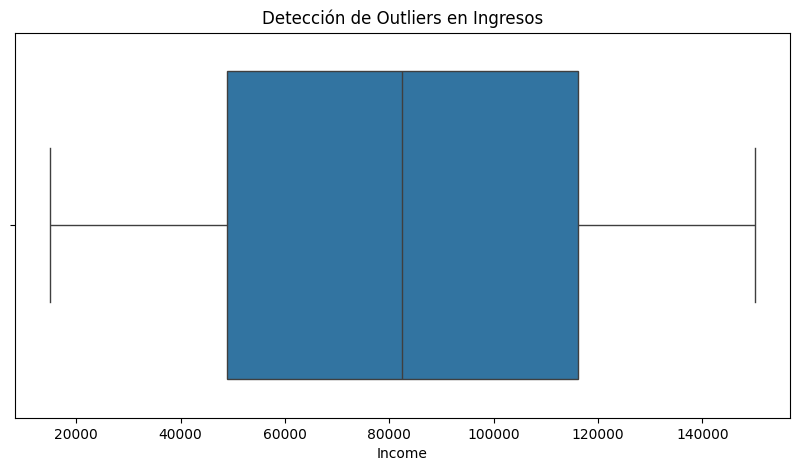

In [41]:
# Identificación de outliers en 'Income'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['Income'])
plt.title('Detección de Outliers en Ingresos')
plt.show()

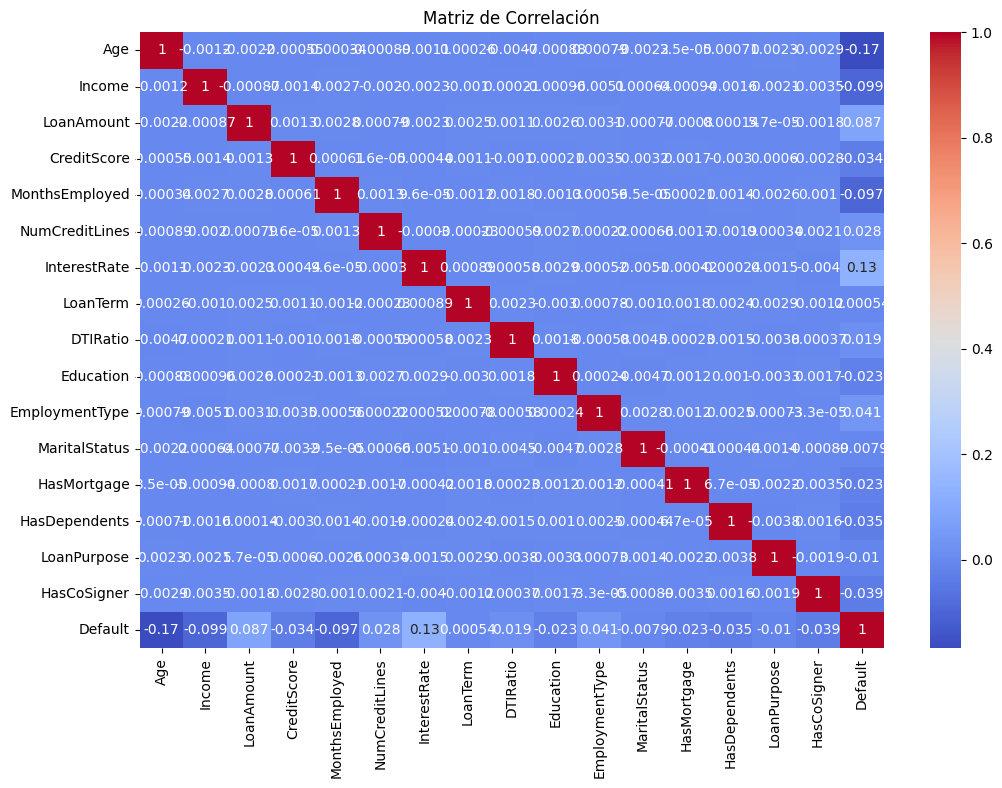

In [42]:
# Filtrar solo las columnas numéricas
numeric_df = df.select_dtypes(include='number')

# Matriz de correlación
corr_matrix = numeric_df.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()


In [43]:
# Estadísticas descriptivas de 'Income'
print(df['Income'].describe())

# Estadísticas descriptivas de 'CreditScore'
print(df['CreditScore'].describe())


count    255347.000000
mean      82499.304597
std       38963.013729
min       15000.000000
25%       48825.500000
50%       82466.000000
75%      116219.000000
max      149999.000000
Name: Income, dtype: float64
count    255347.000000
mean        574.264346
std         158.903867
min         300.000000
25%         437.000000
50%         574.000000
75%         712.000000
max         849.000000
Name: CreditScore, dtype: float64


# 3. Hipótesis sobre los datos

Hipótesis 1: Las personas con un alto Income (ingresos) tienen menos probabilidad de incumplimiento de pago. Se valida esta hipótesis.

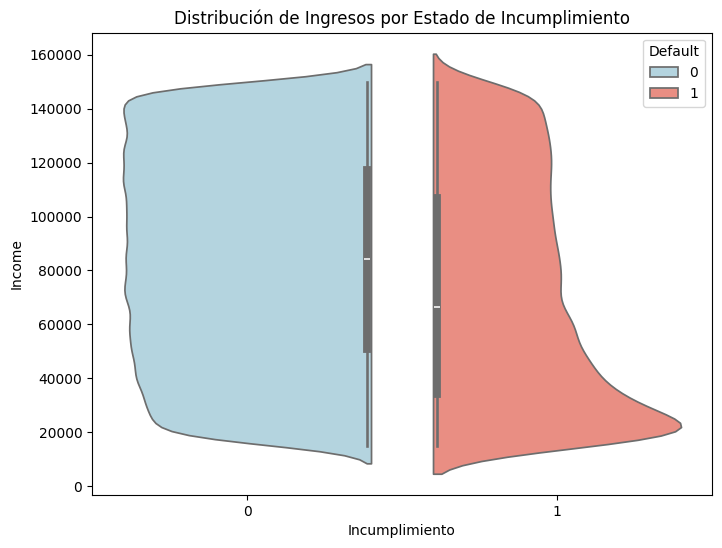

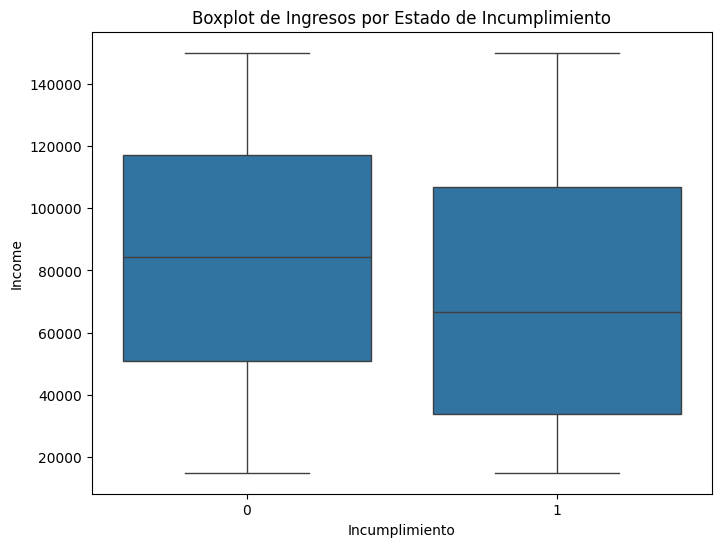

Coeficiente de correlación entre Income y Default: -0.09911948445660432


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, f1_score

# Visualización de Datos
# Gráfico de Violin
plt.figure(figsize=(8, 6))
sns.violinplot(x='Default', y='Income', data=df, hue='Default', palette=['lightblue', 'salmon'], split=True)
plt.title('Distribución de Ingresos por Estado de Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Income')
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='Income', data=df)
plt.title('Boxplot de Ingresos por Estado de Incumplimiento')
plt.xlabel('Incumplimiento')
plt.ylabel('Income')
plt.show()

# Análisis Estadístico
# Correlación
correlation = df[['Income', 'Default']].corr().loc['Income', 'Default']
print(f'Coeficiente de correlación entre Income y Default: {correlation}')

Podemos ver que los ingresos de quienes incumplen son más bajos en promedio. Ademas, el coeficiente de correlacion nos indica que hay una relacion lineal negativa, es decir, entre mas bajo, mas chances de incumplimiento. 

Hipótesis 2: Un mayor número de cuotas distribuye el pago total del préstamo en períodos más largos, lo que reduce el monto de cada cuota mensual, reduce la probabilidad de incumplimiento. Se refuta esta hipótesis.

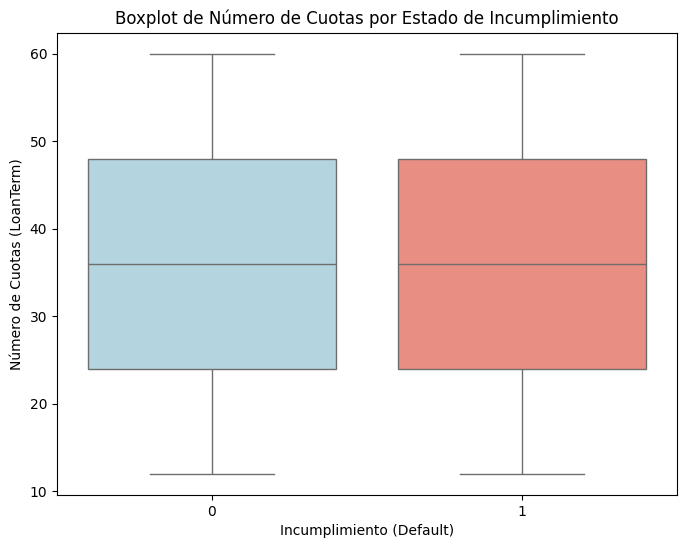

Coeficiente de correlación entre LoanTerm y Default: 0.0005446976963164581


In [20]:
# Boxplot para 'LoanTerm' por estado de incumplimiento
palette = {0: 'lightblue', 1: 'salmon'}

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='LoanTerm', data=df, hue='Default', palette=palette, legend=False)

# Añadir título y etiquetas
plt.title('Boxplot de Número de Cuotas por Estado de Incumplimiento')
plt.xlabel('Incumplimiento (Default)')
plt.ylabel('Número de Cuotas (LoanTerm)')

# Mostrar el gráfico
plt.show()

# Análisis Estadístico
# Correlación
correlation = df[['LoanTerm', 'Default']].corr().loc['LoanTerm', 'Default']
print(f'Coeficiente de correlación entre LoanTerm y Default: {correlation}')

No se cumple, debido a que no hay una tendencia que implique que a mayor cantidad de cuotas menor la chance de incumplimiento. Ademas, podemos ver una correlacion muy cercana a 0 lo que implica que no hay una relacion lineal entre LoanTerm y Defautl.

Hipótesis 3: Nivel de CreditScore, a mayor nivel, mas chance de incumplimiento . Se refuta esta hipótesis.

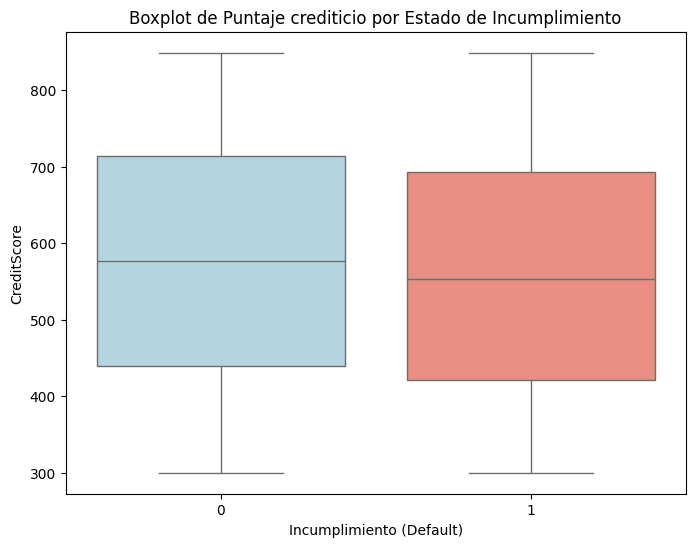

Coeficiente de correlación entre CreditScore y Default: -0.03416649376077075


In [21]:
# Boxplot para 'LoanTerm' por estado de incumplimiento
palette = {0: 'lightblue', 1: 'salmon'}

# Crear el boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='CreditScore', data=df, hue='Default', palette=palette, legend=False)

# Añadir título y etiquetas
plt.title('Boxplot de Puntaje crediticio por Estado de Incumplimiento')
plt.xlabel('Incumplimiento (Default)')
plt.ylabel('CreditScore')

# Mostrar el gráfico
plt.show()

# Análisis Estadístico
# Correlación
correlation = df[['CreditScore', 'Default']].corr().loc['CreditScore', 'Default']
print(f'Coeficiente de correlación entre CreditScore y Default: {correlation}')

Para esta hipotesis, podemos refutar viendo que las personas que no incumplieron en promedio tienen un CreditScore mayor a las que si lo hicieron. Ademas, el coeficiente de correlacion nos indica que entre mayor CreditScore, menor posibilidad de incumplimiento hay. 

Hallazgos Adicionales:

InterestRate y Default: La correlación entre InterestRate y Default es positiva (0.131273), indicando que un aumento en la tasa de interés está asociado con un mayor riesgo de incumplimiento. Esto puede tener sentido, ya que tasas de interés más altas pueden hacer que los pagos sean más difíciles de manejar.

HasMortgage y Default: La correlación entre HasMortgage y Default es negativa (-0.022856), lo que sugiere una relación débil y posiblemente no significativa entre tener una hipoteca y el incumplimiento.

Impacto en la Creación del Modelo:

Incluir Income: Basado en la hipótesis validada, Income es una variable importante a incluir en el modelo predictivo, ya que tiene una relación significativa con la probabilidad de incumplimiento.

Tasa de Interés: Dado el hallazgo de una relación positiva entre InterestRate y Default, es crucial incluir esta variable en el modelo para capturar su impacto en la probabilidad de incumplimiento.

Creación de Nuevas Variables:

Ratio Ingresos a Deuda (IncomeToDebtRatio): Crear una nueva variable que represente la relación entre Income y LoanAmount puede ser beneficioso. Esta variable podría proporcionar información adicional sobre la capacidad de pago de una persona en relación con su nivel de deuda.

Interacción entre Income y InterestRate: Una variable que capture la interacción entre Income y InterestRate podría ayudar a identificar cómo los ingresos y las tasas de interés combinados afectan el riesgo de incumplimiento.

# 4. Modelado

Metricas:

Recall es crítico porque queremos identificar a la mayor cantidad de clientes que incumpliran para tomar medidas correctivas.

Precisión también es importante para evitar etiquetar incorrectamente a clientes que no están en incumplimiento, ya que esto puede llevar a decisiones incorrectas y acciones innecesarias.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Seleccionar solo las columnas numéricas
df_numeric = df.select_dtypes(include=['number'])

# Suponiendo que 'Default' es la variable objetivo
X = df_numeric.drop('Default', axis=1)
y = df_numeric['Default']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo con el escalador y la regresión logística
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Ajustar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Calcular el F1-Score
f1 = f1_score(y_test, y_pred)

print(f'F1-Score: {f1}')


F1-Score: 0.0398096062310688


Aplicar alguna técnica de feature engineering para mejorar los datos de entrada a los modelos, y mostrar la comparativa de los resultados obtenidos en cada caso. Si no es posible o útil, fundamentar el motivo por el cual no se realizará.